# Object Detection with KerasCV

In [1]:
#!pip install -q -r requirements.txt


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [1]:
!pip install --upgrade keras
!pip install --upgrade keras-cv

  Obtaining dependency information for keras from https://files.pythonhosted.org/packages/b0/b2/104733bb67fde86f3d10010f0b5c93cfa1d5bf552f904584cf9e5b3ba719/keras-3.0.5-py3-none-any.whl.metadata
  Obtaining dependency information for rich from https://files.pythonhosted.org/packages/be/be/1520178fa01eabe014b16e72a952b9f900631142ccd03dc36cf93e30c1ce/rich-13.7.0-py3-none-any.whl.metadata
  Obtaining dependency information for namex from https://files.pythonhosted.org/packages/cd/43/b971880e2eb45c0bee2093710ae8044764a89afe9620df34a231c6f0ecd2/namex-0.0.7-py3-none-any.whl.metadata
  Obtaining dependency information for dm-tree from https://files.pythonhosted.org/packages/08/e2/4c29cb9876456517f21979ddcbb6048f28a3b52c61aa9d14d42adafcdca4/dm_tree-0.1.8-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for markdown-it-py>=2.2.0 from https://files.pythonhosted.org/packages/42/d7/1ec15b46af6af88f19b8e5ffea08fa375d433c998b8a7639e76935c14f1f/markdown_it_py-3.0.0-py3-no

In [1]:
import keras
print(keras.__version__)

3.0.5


In [2]:
import keras_cv
print(keras_cv.__version__)

/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.8.2


In [3]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm

In [4]:
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
)

100%|██████████| 2.27k/2.27k [00:00<00:00, 2.22MB/s]
100%|██████████| 99.5M/99.5M [01:05<00:00, 1.60MB/s]


1215963/1215963 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


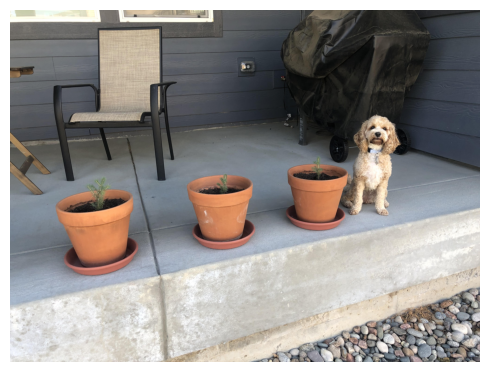

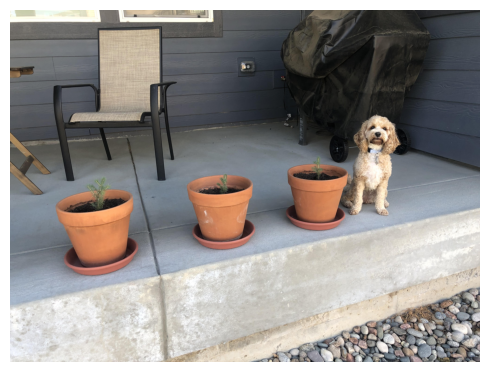

In [5]:
filepath = keras.utils.get_file(origin="https://i.imgur.com/gCNcJJI.jpg")
image = keras.utils.load_img(filepath)
image = np.array(image)

visualization.plot_image_gallery(
    np.array([image]),
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
)

In [6]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)

In [7]:
image_batch = inference_resizing([image])

In [8]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


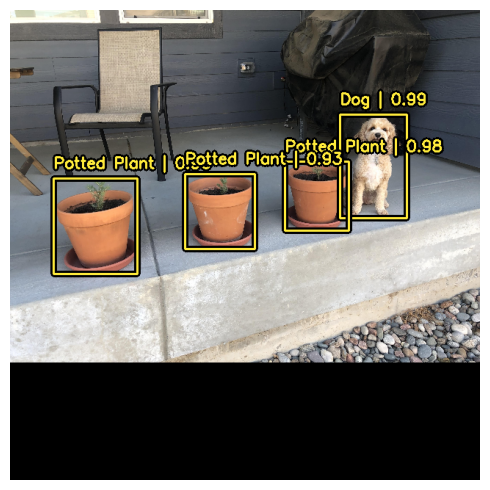

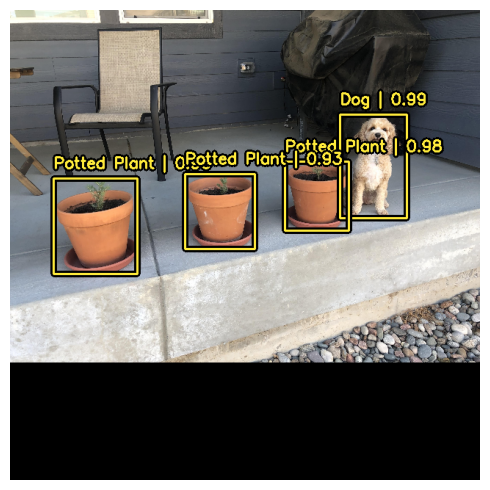

In [9]:
y_pred = pretrained_model.predict(image_batch)
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


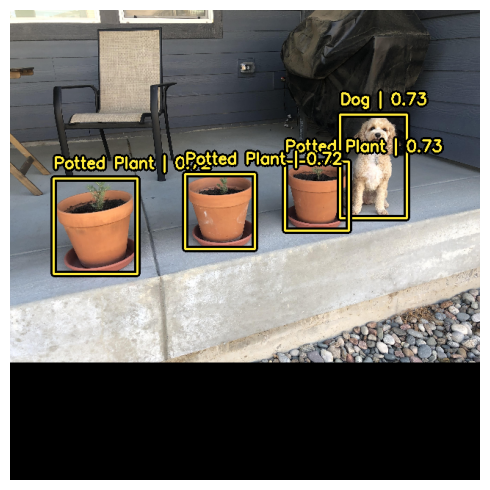

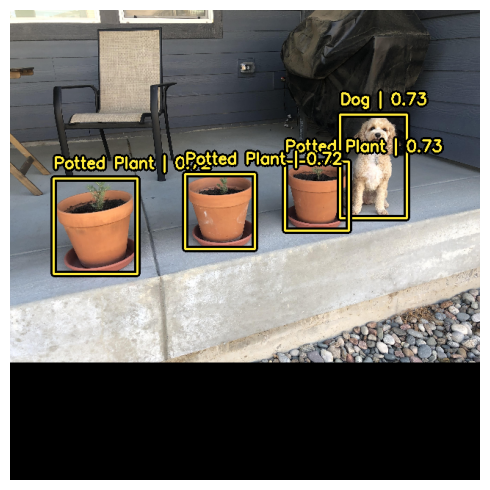

In [11]:
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    # Decrease the required threshold to make predictions get pruned out
    iou_threshold=0.2,
    # Tune confidence threshold for predictions to pass NMS
    confidence_threshold=0.7,
)
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",
    bounding_box_format="xywh",
    prediction_decoder=prediction_decoder,
)

y_pred = pretrained_model.predict(image_batch)
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

# Custom

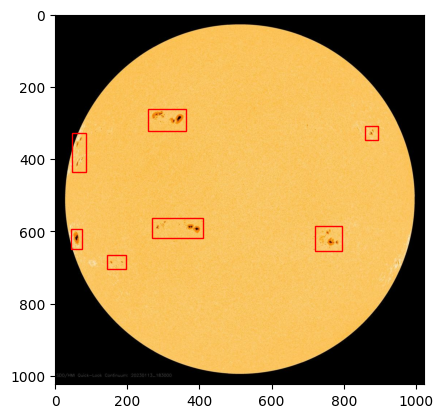

In [73]:
import tensorflow as tf
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define function to parse XML
def parse_xml(xml_content, image_width, image_height):
    root = ET.fromstring(xml_content)
    boxes = []
    classes = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)
        # Convert bounding box to "rel_xywh" format
        width = xmax - xmin
        height = ymax - ymin
        x_center = xmin + width / 2
        y_center = ymin + height / 2
        rel_x_center = x_center / image_width
        rel_y_center = y_center / image_height
        rel_width = width / image_width
        rel_height = height / image_height
        boxes.append([rel_x_center, rel_y_center, rel_width, rel_height])
        classes.append(name)
    return boxes, classes

# Define function to load image and annotation
def load_img_and_annotation(image_path, xml_path, image_width, image_height):
    img = tf.io.read_file(image_path)  # Read the image file
    img = tf.image.decode_jpeg(img, channels=3)  # Decode JPEG image
    
    with open(xml_path, 'r') as f:
        xml_content = f.read()
    
    boxes, classes = parse_xml(xml_content, image_width, image_height)
    
    bounding_boxes = {
        "boxes": boxes,
        "classes": classes
    }
    
    return {"images": img, "bounding_boxes": bounding_boxes}

# Define function for visualization
def visualize_image_with_boxes(data):
    fig, ax = plt.subplots(1)
    ax.imshow(image.numpy())
    for box in data['bounding_boxes']["boxes"]:
        x_center, y_center, width, height = box
        x_min = (x_center - width / 2) * image.shape[1]
        y_min = (y_center - height / 2) * image.shape[0]
        rect = patches.Rectangle((x_min, y_min), width * image.shape[1], height * image.shape[0], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

# Example usage:
image_path = "dataset/voc_v1/test/20230113_183000_1024_HMIIF_jpg.rf.06e825a36d04ce09fd040f3a6dc5abcc.jpg"
xml_path = "dataset/voc_v1/test/20230113_183000_1024_HMIIF_jpg.rf.06e825a36d04ce09fd040f3a6dc5abcc.xml"
image_width = 1024
image_height = 1024
data = load_img_and_annotation(image_path, xml_path, image_width, image_height)
visualize_image_with_boxes(data)


# Dataset

In [9]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0

In [18]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

class_ids = [
    "flare",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids

# Path to images and annotations
path_images = "./dataset/voc_v1/data/images/"
path_annot = "./dataset/voc_v1/data/annotations/"

# Get all XML file paths in path and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

# Now, you should iterate over xml_files and pass path to parse_annotation
image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

100%|██████████| 23/23 [00:00<00:00, 7424.69it/s]


In [19]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [20]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [21]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [22]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

In [23]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [24]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)


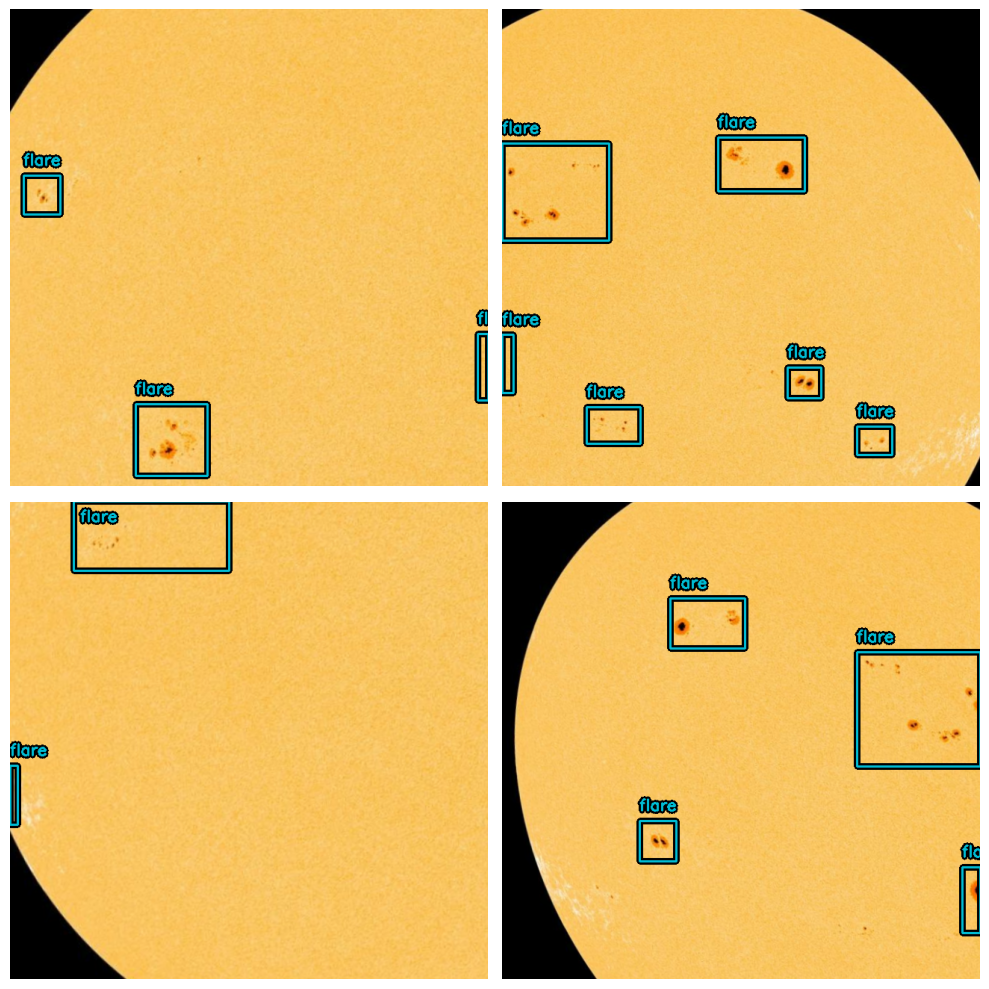

In [25]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [26]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [27]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

100%|██████████| 646/646 [00:00<00:00, 627kB/s]
100%|██████████| 19.7M/19.7M [00:03<00:00, 5.40MB/s]


In [28]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

In [29]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [30]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [31]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)

Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 577.7092

2024-03-02 15:22:25.593143: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: ImportError: compute_pycoco_metrics requires the `pycocotools` package. Please install the package using `pip install pycocotools`.
Traceback (most recent call last):

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.11/site-packages/tens

UnknownError: {{function_node __wrapped__EagerPyFunc_Tin_1_Tout_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} ImportError: compute_pycoco_metrics requires the `pycocotools` package. Please install the package using `pip install pycocotools`.
Traceback (most recent call last):

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.11/site-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 205, in result_on_host_cpu
    return tf.constant(obj_result(force), obj.dtype)
                       ^^^^^^^^^^^^^^^^^

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.11/site-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 256, in result
    self._cached_result = self._compute_result()
                          ^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.11/site-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 263, in _compute_result
    metrics = compute_pycocotools_metric(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.11/site-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 315, in compute_pycocotools_metric
    return coco.compute_pycoco_metrics(ground_truth, predictions)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.11/site-packages/keras_cv/src/metrics/coco/pycoco_wrapper.py", line 216, in compute_pycoco_metrics
    assert_pycocotools_installed("compute_pycoco_metrics")

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.11/site-packages/keras_cv/src/utils/conditional_imports.py", line 68, in assert_pycocotools_installed
    raise ImportError(

ImportError: compute_pycoco_metrics requires the `pycocotools` package. Please install the package using `pip install pycocotools`.

 [Op:EagerPyFunc] name: 

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")